# Random forest on single-cell RNA-seq data


![Pando](https://sciencetonnante.files.wordpress.com/2014/10/1024px-fallpando02.jpg)
Pando

In [30]:
library(randomForest)
library(ranger) #RF optimisées pour calcul parallèle et grande dimension
library(edarf) # Pour extraire la proximité de la ranger RF
library(varhandle) # pour la fonction unfactor qui annule la facheuse tendance qu'à R de tout convertir en factors...

## Acquisition et nettoyage des données

In [31]:
Data = read.table("GSE57872_GBM_data_matrix.txt", sep="\t")

In [32]:
for (i in 2:dim(Data)[2]){
    colnames(Data)[i]= as.character(Data[1,i])
}
for (i in 2:dim(Data)[1]){
    rownames(Data)[i]= as.character(Data[i,1])
}

Data = Data[-1,] ; Data = Data[,-1]

In [33]:
#On retire les Cancer Stem Cells
CSC_cols = numeric(0)
for (i in 1:length(colnames(Data)) ){
    if (grepl("CSC", colnames(Data)[i]) || grepl("FCS", colnames(Data)[i]) || grepl("Tumor", colnames(Data)[i])) {CSC_cols = c(CSC_cols, i)}
}
Data = Data[-CSC_cols]

In [34]:
#On transpose le data frame pour avoir les gênes en colonnes et les cellules en lignes
df2 = data.frame(t(Data))
Data = df2

Data = unfactor(Data)

<br><br><br><br><br><br>


# Unsupervised Random Forest avec Addcl1 :

# TEST 1 : URF sur l'ensemble des données

## Hyperparamètres : 

In [35]:
nb_forests = 5 # nombre de forets
nb_trees = 3000 # nombre d'arbres par forets
nb_cells = dim(Data)[1] # nombre de cellules (lignes du data frame)
nb_genes = dim(Data)[2] # nombre de gènes (colones du data frame)
mtry = sqrt(nb_genes) # nombre de variables (gènes) testés à chaque splits des arbres

## Addcl1

In [36]:
addcl1 = function(dat) {
        bootstrap = function(X)   { sample(X, replace=T) } 
        col_bootstrap = function(dat) { apply(dat,2, bootstrap) } #On bootstrap sur chaque colonne
        nrow <- dim(dat)[1];
        Classe <- rep(c(1,2),c(nrow,nrow) ) #Un vecteur contenant nb_obs 1 et nb_obs 2, les classes sur lesquelles la URF va travailler
        data.frame(cbind(Classe,rbind(dat,data.frame(col_bootstrap(dat)))))
    }

## VarImpPlot pour multi-forets (adapté pour ranger)
Adaptation du code source de VarImpPlot sur cette page pour le cas multi-forets (https://github.com/cran/randomForest/blob/master/R/varImpPlot.R)

In [37]:
varImpPlot_mult = function(imp, sort=TRUE,
                       n.var=min(30, nrow(imp)),
                       main=deparse(substitute(x)), ...) {
    if (ncol(data.frame(imp)) == 1){#Reshape des données pour que ça marche avec la library Ranger en mode "permutation" 
        imp2 = data.frame(imp)
        a = array(imp2[,1], c(dim(imp2)[1], 1) )
        colnames(a) = "MeanDecreaseAccuracy"
        rownames(a) = rownames(imp2)
        imp = a
    }
    
    if (ncol(imp) > 2) imp <- imp[, -(1:(ncol(imp) - 2))]
    nmeas = ncol(imp)
    if (nmeas > 1) {
        op = par(mfrow=c(1, 2), mar=c(4, 5, 4, 1), mgp=c(2, .8, 0),
                  oma=c(0, 0, 2, 0), no.readonly=TRUE)
        on.exit(par(op))
    }
    for (i in 1:nmeas) {
        ord <- if (sort) rev(order(imp[,i],
                                   decreasing=TRUE)[1:n.var]) else 1:n.var
        xmin <- if (colnames(imp)[i] %in%
                    c("IncNodePurity", "MeanDecreaseGini")) 0 else min(imp[ord, i])
        dotchart(imp[ord,i], xlab=colnames(imp)[i], ylab="",
                 main=if (nmeas == 1) main else NULL,
                 xlim=c(xmin, max(imp[,i])), ...)
    }
    if (nmeas > 1) mtext(outer=TRUE, side=3, text=main, cex=1.2)
    invisible(imp)
}

## MDSplot pour multi-forets
Adaptation du code source de VarImpPlot sur cette page pour le cas multi-forets (https://github.com/cran/randomForest/blob/master/R/MDSplot.R)

In [38]:
MDSplot_mult <- function(diss, fac, k=2, palette=NULL, pch=20, ...) {
    op <- par(pty="s")
    on.exit(par(op))
    rf.mds <- stats::cmdscale(diss, eig=TRUE, k=k)
    colnames(rf.mds$points) <- paste("Dim", 1:k)
    nlevs <- nlevels(fac)
    if (is.null(palette)) {
        palette <- if (requireNamespace("RColorBrewer", quietly = TRUE) && nlevs < 12)
            RColorBrewer::brewer.pal(nlevs, "Set1") else rainbow(nlevs)
    }
    if (k <= 2) {
        plot(rf.mds$points, col=palette[as.numeric(fac)], pch=pch, ...)
    } else {
        pairs(rf.mds$points, col=palette[as.numeric(fac)], pch=pch, ...)
    }
    invisible(rf.mds)
}

## Forêt

Computing permutation importance.. Progress: 49%. Estimated remaining time: 31 seconds.
Computing permutation importance.. Progress: 97%. Estimated remaining time: 1 seconds.
Computing permutation importance.. Progress: 49%. Estimated remaining time: 32 seconds.
Computing permutation importance.. Progress: 96%. Estimated remaining time: 2 seconds.
Computing permutation importance.. Progress: 49%. Estimated remaining time: 32 seconds.
Computing permutation importance.. Progress: 95%. Estimated remaining time: 3 seconds.
Computing permutation importance.. Progress: 49%. Estimated remaining time: 32 seconds.
Computing permutation importance.. Progress: 96%. Estimated remaining time: 2 seconds.
Computing permutation importance.. Progress: 49%. Estimated remaining time: 32 seconds.
Computing permutation importance.. Progress: 96%. Estimated remaining time: 2 seconds.


Ranger result

Call:
 ranger(factor(target) ~ ., data = DataRFsyn[, -1], num.trees = nb_trees,      mtry = mtry, importance = "permutation") 

Type:                             Classification 
Number of trees:                  3000 
Sample size:                      860 
Number of independent variables:  5948 
Mtry:                             77 
Target node size:                 1 
Variable importance mode:         permutation 
Splitrule:                        gini 
OOB prediction error:             0.00 % 

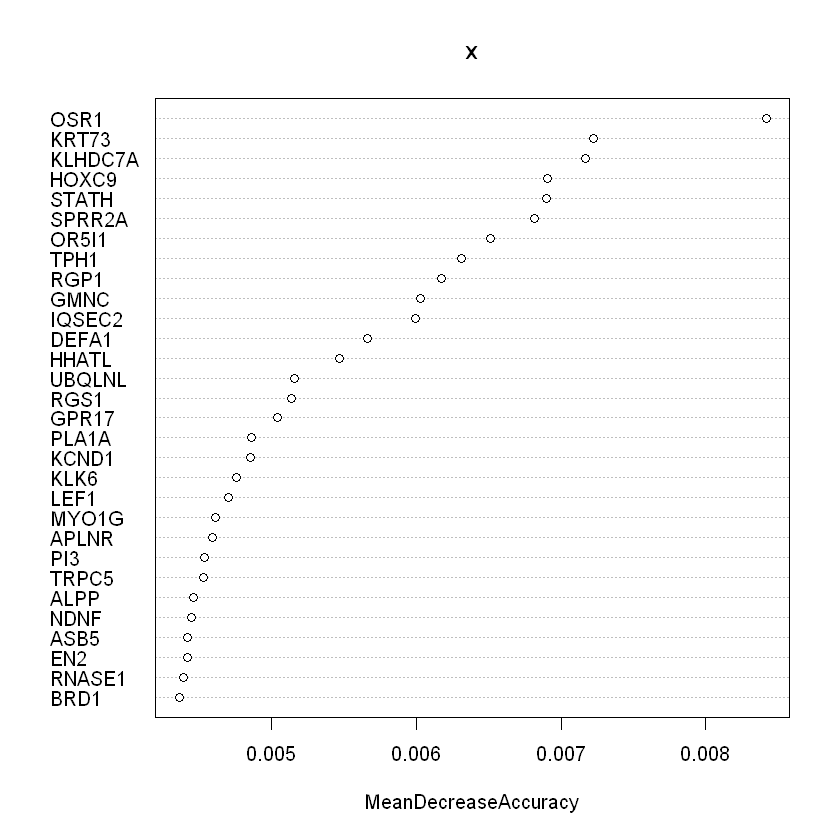

In [39]:
RFproxTotal = matrix(0, nb_cells, nb_cells)
RFimportance = matrix(0, nrow=nb_genes, ncol=1)
for (i in 1:nb_forests){
    DataRFsyn = addcl1(Data)
    target = DataRFsyn[,1]
    RF = ranger(factor(target)~.,
                data = DataRFsyn[,-1], 
                num.trees = nb_trees,
                mtry = mtry, 
                importance = 'permutation') 
    
    RFproxTotal = RFproxTotal + extract_proximity(RF, DataRFsyn)[1:nb_cells, 1:nb_cells]
    RFimportance = RFimportance + (1/nb_forests)*(data.frame(RF$variable.importance))
}
RFproxTotal = RFproxTotal/nb_forests


RF
varImpPlot_mult(RFimportance)

## MDS

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

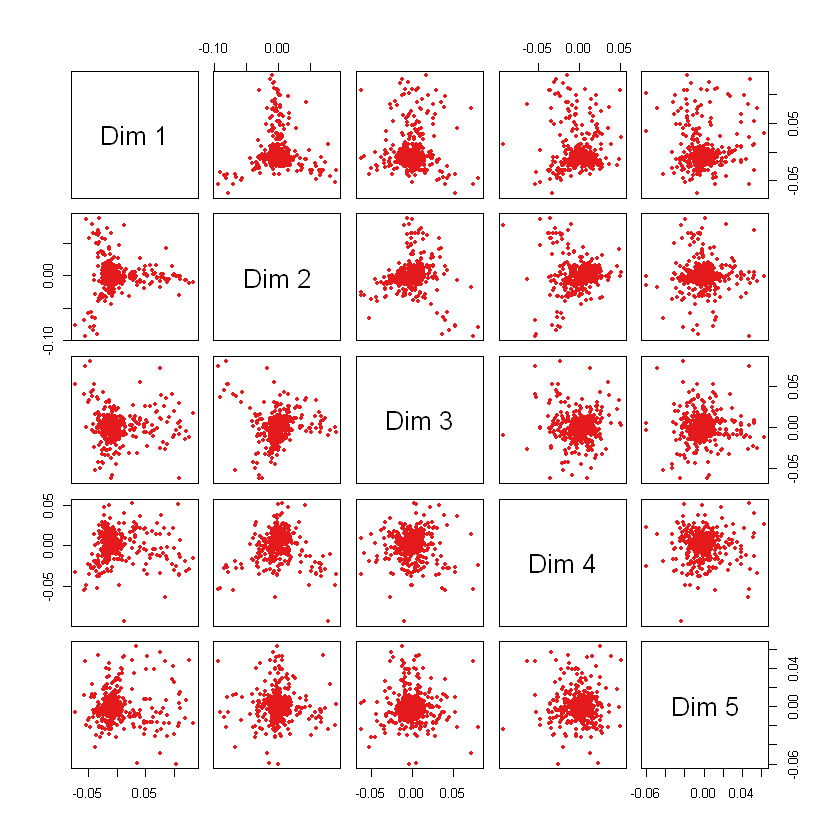

In [40]:
DISS = 1-RFproxTotal #la matrice de dissimilarité de la random forest
MDSplot_mult(DISS, as.factor(target), k=5)

## MDS coloré selon les patients

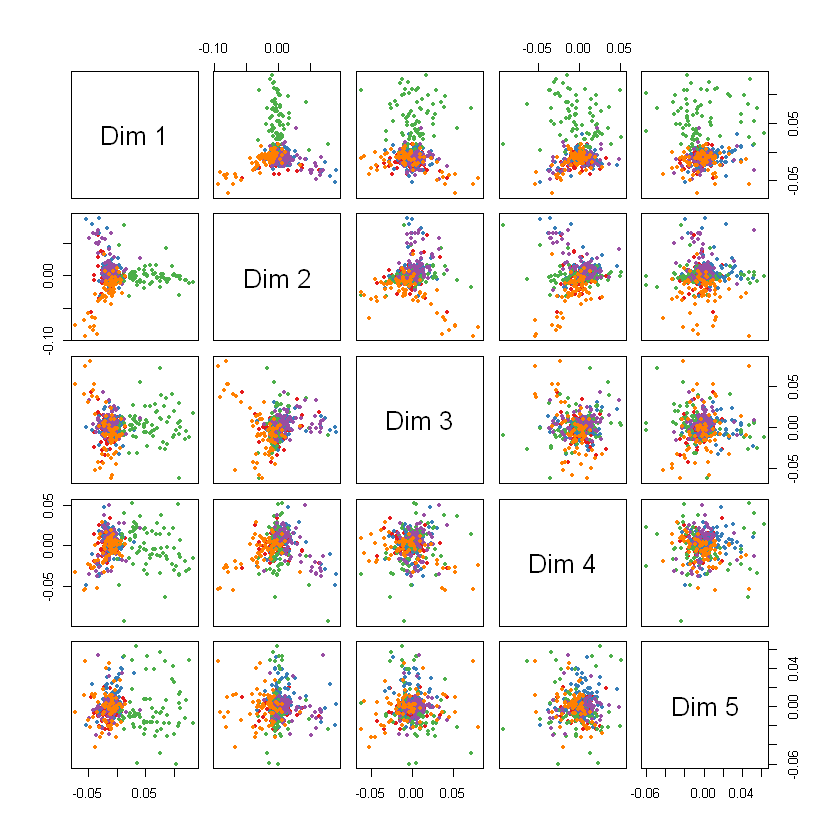

In [41]:
nb_pats = numeric(5)
for (i in rownames(Data)) {
    if (grepl('MGH26', i)) {nb_pats[1] = nb_pats[1] + 1}
    else if (grepl('MGH28', i)) {nb_pats[2] = nb_pats[2] + 1}
    else if (grepl('MGH29', i)) {nb_pats[3] = nb_pats[3] + 1}
    else if (grepl('MGH30', i)) {nb_pats[4] = nb_pats[4] + 1}
    else if (grepl('MGH31', i)) {nb_pats[5] = nb_pats[5] + 1}
}
target_pats = rep(c(1,2,3,4,5), nb_pats)
MDSplot_mult(DISS, as.factor(target_pats), k=5)

<br><br><br><br><br>
# TEST 2 : 
# On entraine la RF à différencier deux patients.

In [42]:
# Créé un dataframe contenant les données de deux patients à comparer.
# Les patiens disponibles sont : MGH26, MGH28, MGH29, MGH30, MGH31.
select_patients = function(Data, pat1 = 'MGH26', pat2 = 'MGH28'){
    not_pat_rows = numeric(0)
    for (i in 1:length(colnames(Data)) ){
        if ( !(grepl(pat1, rownames(Data)[i]) || grepl(pat2, rownames(Data)[i])) ) {not_pat_rows = c(not_pat_rows, i)}
    }
    return(Data[-not_pat_rows,])
}

## Addcl_pat

In [43]:
addcl_pat = function(dat, pat1 = 'MGH26', pat2 = 'MGH28'){
    nb_pat1 = 0 ; nb_pat2 = 0
    for (i in rownames(dat)) {
        if (grepl(pat1, i)) {nb_pat1 = nb_pat1 + 1}
        else {nb_pat2 = nb_pat2 +1}
    }
    Classe = rep( c(1,2),c(nb_pat1, nb_pat2) )
    data.frame( cbind(Classe, dat) )
}

In [44]:
pat1 = 'MGH26' ; pat2 = 'MGH28'
Data_patients = select_patients(Data, pat1, pat2)

## Hyperparamètres

In [45]:
nb_forests_2 = 5 # nombre de forets
nb_trees_2 = 3000 # nombre d'arbres par forets
nb_cells_2 = dim(Data_patients)[1] # nombre de cellules (lignes du data frame)
nb_genes_2 = dim(Data_patients)[2] # nombre de gènes (colones du data frame)
mtry_2 = sqrt(nb_genes_2) # nombre de variables (gènes) testés à chaque splits des arbres

## Foret

Ranger result

Call:
 ranger(factor(target2) ~ ., data = DataRFsyn2[, -1], num.trees = nb_trees_2,      mtry = mtry_2, importance = "permutation") 

Type:                             Classification 
Number of trees:                  3000 
Sample size:                      212 
Number of independent variables:  5948 
Mtry:                             77 
Target node size:                 1 
Variable importance mode:         permutation 
Splitrule:                        gini 
OOB prediction error:             0.00 % 

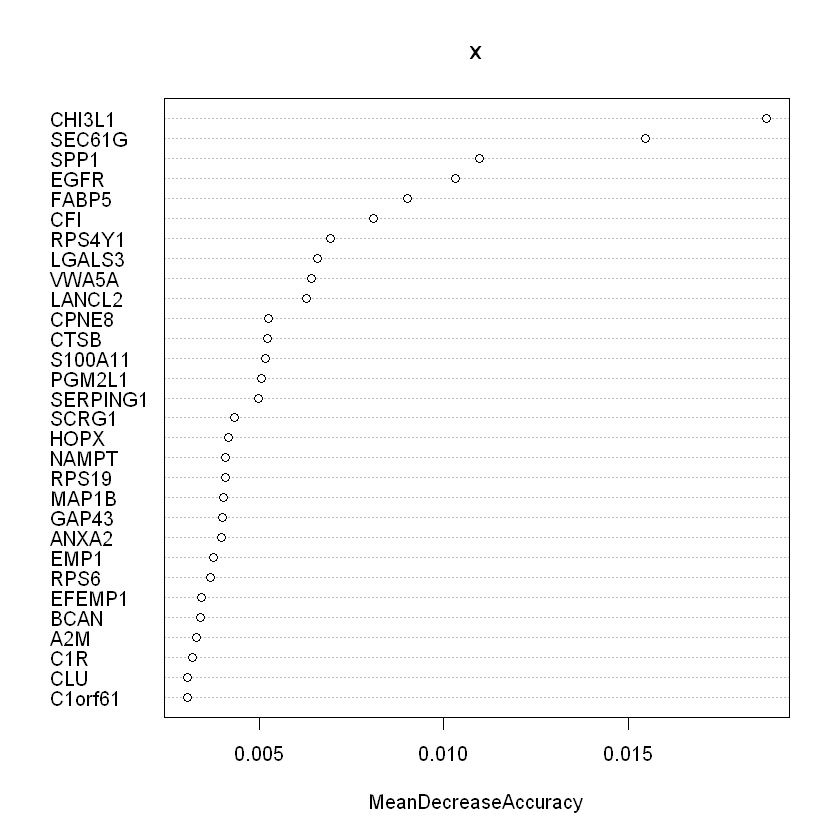

In [46]:
RFproxTotal2 = matrix(0, nb_cells_2, nb_cells_2)
RFimportance2 = matrix(0, nrow=nb_genes_2, ncol=4)
for (i in 1:nb_forests_2){
    DataRFsyn2 = addcl_pat(Data_patients, pat1, pat2)
    target2 = DataRFsyn2[,1]
    RF2 = ranger(factor(target2)~.,
                data = DataRFsyn2[,-1], 
                num.trees = nb_trees_2,
                mtry = mtry_2, 
                importance = 'permutation')
    
    RFproxTotal2 = RFproxTotal2 + extract_proximity(RF2, DataRFsyn2)[1:nb_cells_2, 1:nb_cells_2]
    RFimportance2 = RFimportance2 + (1/nb_forests_2)*(data.frame(RF2$variable.importance))
}
RFproxTotal2 = RFproxTotal2/nb_forests_2


RF2
varImpPlot_mult(RFimportance2)

## MDS

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

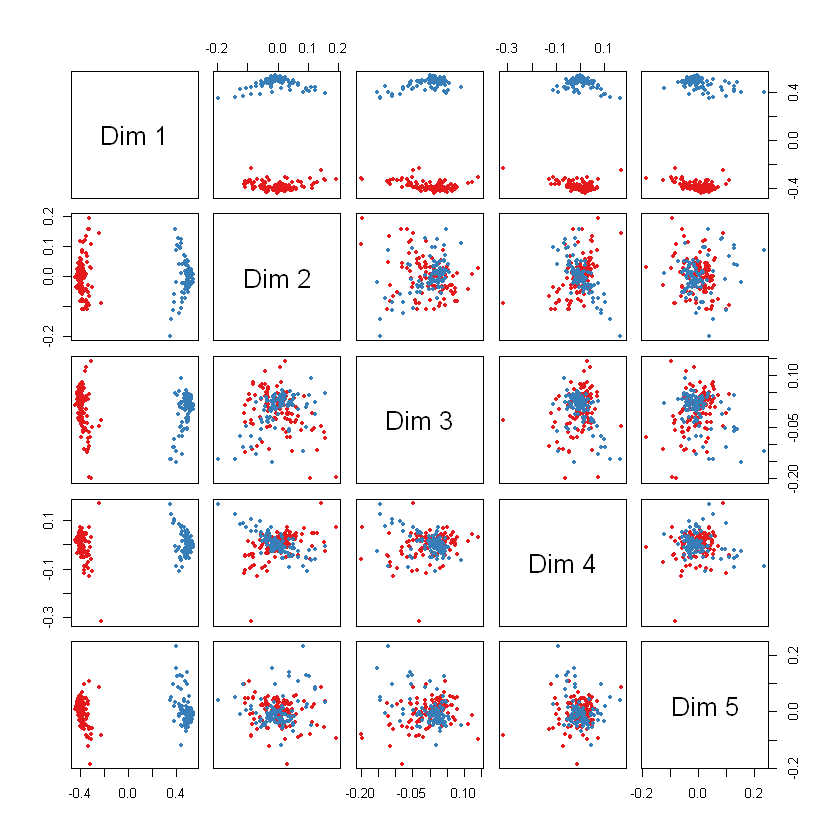

In [47]:
DISS2 = 1-RFproxTotal2 #la matrice de dissimilarité de la random forest
MDSplot_mult(DISS2, as.factor(target2), k=5)

 # TEST 3 : 
 ## On entraine la RF sur un seul patient avec Addcl1

In [48]:
# Créé un dataframe contenant les données du patient à analyser.
# Les patiens disponibles sont : MGH26, MGH28, MGH29, MGH30, MGH31.
select_pat = function(Data, pat = 'MGH26'){
    not_pat_rows = numeric(0)
    for (i in 1:length(colnames(Data)) ){
        if ( !(grepl(pat, rownames(Data)[i])) ) {not_pat_rows = c(not_pat_rows, i)}
    }
    return(Data[-not_pat_rows,])
}

In [49]:
pat = 'MGH26'
Data_pat = select_pat(Data, 'MGH26')

## Hyperparamètres

In [50]:
nb_forests_3 = 5 # nombre de forets
nb_trees_3 = 3000 # nombre d'arbres par forets
nb_cells_3 = dim(Data_pat)[1] # nombre de cellules (lignes du data frame)
nb_genes_3 = dim(Data_pat)[2] # nombre de gènes (colones du data frame)
mtry_3 = sqrt(nb_genes_3) # nombre de variables (gènes) testés à chaque splits des arbres


## Foret

Ranger result

Call:
 ranger(factor(target3) ~ ., data = DataRFsyn3[, -1], num.trees = nb_trees_3,      mtry = mtry_3, importance = "permutation") 

Type:                             Classification 
Number of trees:                  3000 
Sample size:                      236 
Number of independent variables:  5948 
Mtry:                             77 
Target node size:                 1 
Variable importance mode:         permutation 
Splitrule:                        gini 
OOB prediction error:             0.00 % 

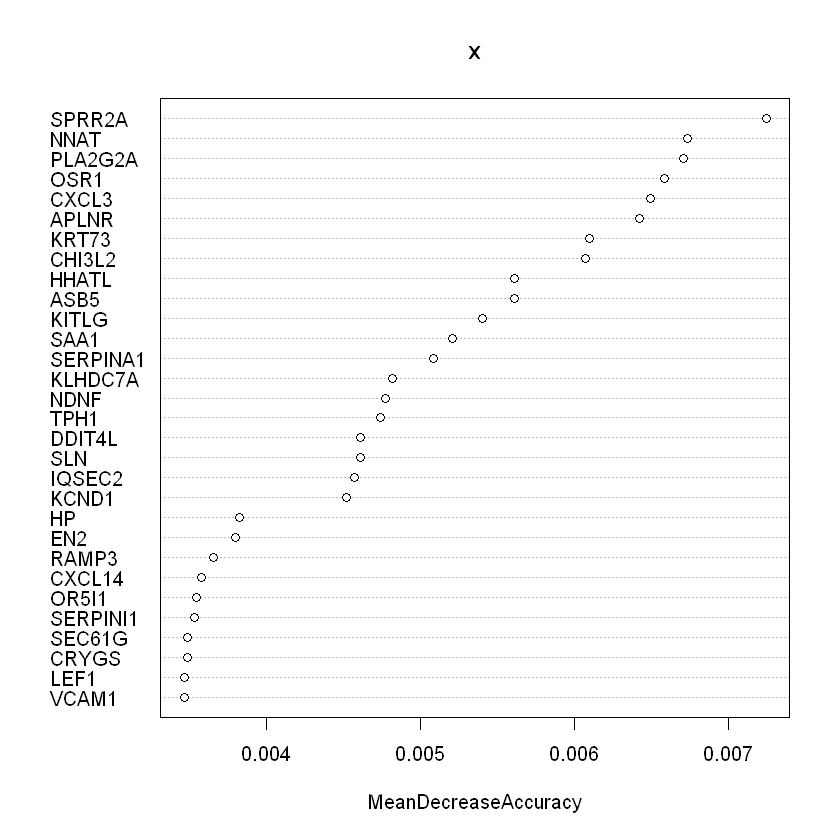

In [51]:
RFproxTotal3 = matrix(0, nb_cells_3, nb_cells_3)
RFimportance3 = matrix(0, nrow=nb_genes_3, ncol=4)
for (i in 1:nb_forests_3){
    DataRFsyn3 = addcl1(Data_pat)
    target3 = DataRFsyn3[,1]
    RF3 = ranger(factor(target3)~.,
                data = DataRFsyn3[,-1], 
                num.trees = nb_trees_3,
                mtry = mtry_3, 
                importance = 'permutation') 
    
    
    RFproxTotal3 = RFproxTotal3 + extract_proximity(RF3, DataRFsyn3)[1:nb_cells_3, 1:nb_cells_3]
    RFimportance3 = RFimportance3 + (1/nb_forests_3)*(data.frame(RF3$variable.importance))
}
RFproxTotal3 = RFproxTotal3/nb_forests_3


RF3
varImpPlot_mult(RFimportance3)

## MDS

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

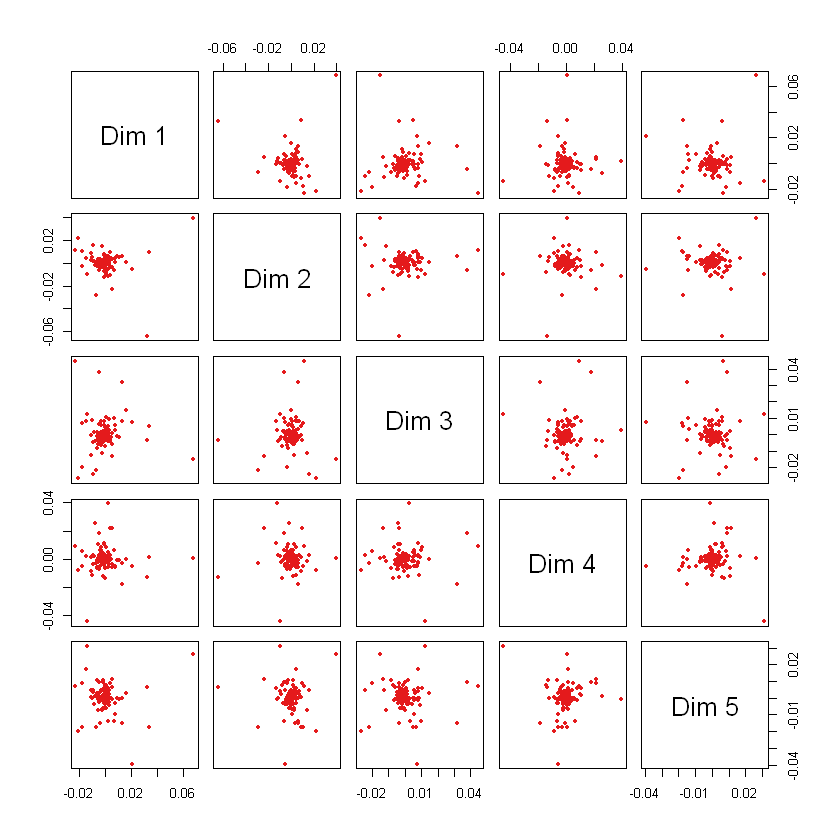

In [52]:
DISS3= 1-RFproxTotal3 #la matrice de dissimilarité de la random forest
MDSplot_mult(DISS3, as.factor(target3), k=5)